# "아침"시간대 유동인구의 추세(trend) 성분 예측

# 1. import library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import gc
import random
import warnings
import pickle
warnings.filterwarnings(action='ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset,DataLoader
import torch.optim as optim
torch.manual_seed(1015)
# define 'device' to upload tensor in gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

import sklearn
from sklearn.neighbors import KNeighborsRegressor
from sklearn.multioutput import MultiOutputRegressor

import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 


from utils.preprocess_utils import *
from utils.train_utils import *

# 2. 데이터 불러오기

In [2]:
### morning data
with open('../data/preprocess/m_data_list.pkl', 'rb') as f:
    data_list = pickle.load(f)
data_list = append_cycle_size(data_list)
train_time, train_notime, train_y,\
valid_time, valid_notime, valid_y, \
    test_time, test_notime, test_y = numpy2tensor(data_list)

# 3. 6가지 모델 훈련

In [3]:
trendcycle = 0
# trend일 때 0
# cycle일 때 1
tc_name = "trend"
model_valid_scores = {f"linear_{tc_name}" : [],
                      f"svm_{tc_name}" : [],
                        f"xgboost_{tc_name}":[],
                         f"lstm_{tc_name}"   :[],
                          f"gru_{tc_name}"    :[],
                          f"lstm_fc_{tc_name}":[],}

## 1) Linear regression

In [4]:
from sklearn.linear_model import LinearRegression
model_name = f"linear_{tc_name}"

In [5]:
X = np.array(train_time[:,:,:].cpu()).reshape(-1,21*12)
y = np.array(train_y[:,:,trendcycle].cpu())
val_X = np.array(valid_time[:,:,:].cpu()).reshape(-1,21*12)
val_y = np.array(valid_y[:,:,trendcycle].cpu())

# fitting
multioutputregressor = MultiOutputRegressor(LinearRegression()).fit(X, y)
# predicting
train_mse = np.mean((multioutputregressor.predict(X) - y)**2)
valid_mse = np.mean((multioutputregressor.predict(val_X) - val_y)**2)
print("train_mse: ", train_mse)
print("valid_mse: ", valid_mse)
model_valid_scores[model_name] = valid_mse

with open(f'best_model/{model_name}.pkl', 'wb') as f:
    pickle.dump(multioutputregressor, f)

train_mse:  0.00608715
valid_mse:  0.017519351


## 2) SVM regressoion

In [6]:
from sklearn.svm import SVR
model_name =  f"svm_{tc_name}"

In [7]:
X = np.array(train_time[:,:,:].cpu()).reshape(-1,21*12)
y = np.array(train_y[:,:,trendcycle].cpu())
val_X = np.array(valid_time[:,:,:].cpu()).reshape(-1,21*12)
val_y = np.array(valid_y[:,:,trendcycle].cpu())

# fitting
multioutputregressor = MultiOutputRegressor(SVR()).fit(X, y)
# predicting
train_mse = np.mean((multioutputregressor.predict(X) - y)**2)
valid_mse = np.mean((multioutputregressor.predict(val_X) - val_y)**2)
print("train_mse: ", train_mse)
print("valid_mse: ", valid_mse)
model_valid_scores[model_name] = valid_mse

with open(f'best_model/{model_name}.pkl', 'wb') as f:
    pickle.dump(multioutputregressor, f)

train_mse:  0.0036505071977054517
valid_mse:  0.016650761811255296


## 3) XGboost

In [8]:
from sklearn.multioutput import MultiOutputRegressor
import xgboost as xgb
model_name =  f"xgboost_{tc_name}"
            # trend일 때 0
            # cycle일 때 1

In [9]:
X = np.array(train_time[:,:,:].cpu()).reshape(-1,21*12)
y = np.array(train_y[:,:,trendcycle].cpu())
val_X = np.array(valid_time[:,:,:].cpu()).reshape(-1,21*12)
val_y = np.array(valid_y[:,:,trendcycle].cpu())

# fitting
multioutputregressor = MultiOutputRegressor(xgb.XGBRegressor(objective='reg:squarederror')).fit(X, y)
# predicting
train_mse = np.mean((multioutputregressor.predict(X) - y)**2)
valid_mse = np.mean((multioutputregressor.predict(val_X) - val_y)**2)
print("train_mse: ", train_mse)
print("valid_mse: ", valid_mse)
model_valid_scores[model_name] = valid_mse

with open(f'best_model/{model_name}.pkl', 'wb') as f:
    pickle.dump(multioutputregressor, f)

train_mse:  0.00015002344
valid_mse:  0.015529792


## 4) LSTM

In [10]:
from models.LSTM import LSTM
model = LSTM(input_size = 12, hidden_size = 32, no_time_size =4).to(device)
model_name = f"lstm_{tc_name}"

10 Epochs train MSE: 0.11049 // valid MSE: 0.06471
20 Epochs train MSE: 0.03393 // valid MSE: 0.04122
30 Epochs train MSE: 0.01938 // valid MSE: 0.03123
40 Epochs train MSE: 0.01288 // valid MSE: 0.02440
50 Epochs train MSE: 0.01011 // valid MSE: 0.01903
60 Epochs train MSE: 0.00816 // valid MSE: 0.01842
70 Epochs train MSE: 0.00703 // valid MSE: 0.01687
80 Epochs train MSE: 0.00625 // valid MSE: 0.01652
90 Epochs train MSE: 0.00565 // valid MSE: 0.01590
100 Epochs train MSE: 0.00515 // valid MSE: 0.01545
110 Epochs train MSE: 0.00471 // valid MSE: 0.01498
120 Epochs train MSE: 0.00434 // valid MSE: 0.01453
130 Epochs train MSE: 0.00400 // valid MSE: 0.01418
140 Epochs train MSE: 0.00370 // valid MSE: 0.01391
150 Epochs train MSE: 0.00343 // valid MSE: 0.01374
160 Epochs train MSE: 0.00320 // valid MSE: 0.01367
170 Epochs train MSE: 0.00299 // valid MSE: 0.01365
180 Epochs train MSE: 0.00281 // valid MSE: 0.01368
190 Epochs train MSE: 0.00265 // valid MSE: 0.01376
200 Epochs train MSE:

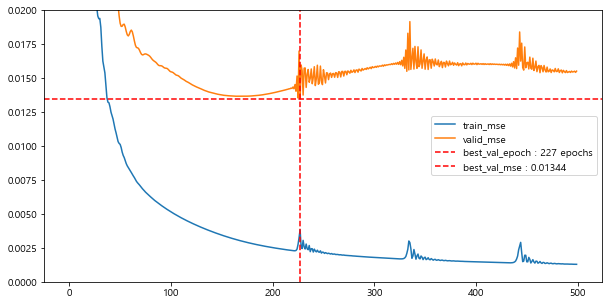

In [11]:
# Train model
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-2)
criterion = nn.MSELoss(size_average = True)
num_epochs  = 500
hist = np.zeros(num_epochs)
train_error = []
valid_error = []
hist = {'best_val_error': 100,
        'best_val_epoch': 0}
for t in range(num_epochs):
    train_trend_pred = model(train_time, train_notime)
    loss = criterion(train_trend_pred, train_y[:,:,trendcycle]) ### trend
    train_error.append(loss)
    valid_trend_pred = model(valid_time, valid_notime)
    valid_mse = float(criterion(valid_trend_pred, valid_y[:,:,trendcycle]).cpu()) ### trend
    valid_error.append(valid_mse)
    if hist['best_val_error'] >= valid_mse:
        hist['best_val_error'] = valid_mse
        hist['best_val_epoch'] = t
        torch.save(model, f'best_model/{model_name}.pkl')
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if t % 10 == 0 and t !=0:
        print(f"{t} Epochs train MSE: {loss.item():1.5f} // valid MSE: {valid_mse:1.5f}")
        
best_model = torch.load( f'best_model/{model_name}.pkl')
train_pred = best_model(train_time, train_notime)
valid_pred = best_model(valid_time, valid_notime)
print('train_error : ',criterion(train_pred, train_y[:,:,trendcycle]))
print('valid_error : ',criterion(valid_pred, valid_y[:,:,trendcycle]))
plot_hist(train_error, valid_error, hist, ylim = 0.02)
model_valid_scores[model_name] = float(criterion(valid_pred, valid_y[:,:,trendcycle]).cpu())

## 5) GRU

In [12]:
from models.GRU import GRU
model = GRU(input_size = 12, hidden_size = 32, no_time_size =4).to(device)
model_name =  f"gru_{tc_name}"

10 Epochs train MSE: 0.11808 // valid MSE: 0.08675
20 Epochs train MSE: 0.03483 // valid MSE: 0.03370
30 Epochs train MSE: 0.01898 // valid MSE: 0.02703
40 Epochs train MSE: 0.01252 // valid MSE: 0.02099
50 Epochs train MSE: 0.00971 // valid MSE: 0.01938
60 Epochs train MSE: 0.00792 // valid MSE: 0.01843
70 Epochs train MSE: 0.00683 // valid MSE: 0.01720
80 Epochs train MSE: 0.00605 // valid MSE: 0.01681
90 Epochs train MSE: 0.00545 // valid MSE: 0.01625
100 Epochs train MSE: 0.00495 // valid MSE: 0.01600
110 Epochs train MSE: 0.00452 // valid MSE: 0.01572
120 Epochs train MSE: 0.00415 // valid MSE: 0.01555
130 Epochs train MSE: 0.00383 // valid MSE: 0.01537
140 Epochs train MSE: 0.00354 // valid MSE: 0.01522
150 Epochs train MSE: 0.00329 // valid MSE: 0.01510
160 Epochs train MSE: 0.00305 // valid MSE: 0.01500
170 Epochs train MSE: 0.00285 // valid MSE: 0.01490
180 Epochs train MSE: 0.00267 // valid MSE: 0.01482
190 Epochs train MSE: 0.00252 // valid MSE: 0.01477
200 Epochs train MSE:

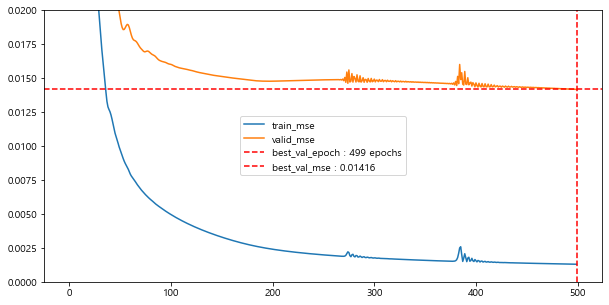

In [13]:
# Train model
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-2)
criterion = nn.MSELoss(size_average = True)
num_epochs  = 500
hist = np.zeros(num_epochs)
train_error = []
valid_error = []
hist = {'best_val_error': 100,
        'best_val_epoch': 0}
for t in range(num_epochs):
    train_trend_pred = model(train_time, train_notime)
    loss = criterion(train_trend_pred, train_y[:,:,trendcycle]) ### trend
    train_error.append(loss)
    valid_trend_pred = model(valid_time, valid_notime)
    valid_mse = float(criterion(valid_trend_pred, valid_y[:,:,trendcycle]).cpu()) ### trend
    valid_error.append(valid_mse)
    if hist['best_val_error'] >= valid_mse:
        hist['best_val_error'] = valid_mse
        hist['best_val_epoch'] = t
        torch.save(model, f'best_model/{model_name}.pkl')
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if t % 10 == 0 and t !=0:
        print(f"{t} Epochs train MSE: {loss.item():1.5f} // valid MSE: {valid_mse:1.5f}")
        
best_model = torch.load( f'best_model/{model_name}.pkl')
train_pred = best_model(train_time, train_notime)
valid_pred = best_model(valid_time, valid_notime)
print('train_error : ',criterion(train_pred, train_y[:,:,trendcycle]))
print('valid_error : ',criterion(valid_pred, valid_y[:,:,trendcycle]))
plot_hist(train_error, valid_error, hist, ylim = 0.02)
model_valid_scores[model_name] = float(criterion(valid_pred, valid_y[:,:,trendcycle]).cpu())

## 6) LSTM, FC 결합 모델

In [14]:
from models.LSTM_FC_trend import LSTM_FC_trend
model = LSTM_FC_trend(input_size = 12, hidden_size = 32, no_time_size =4).to(device)
model_name = f'lstm_fc_{tc_name}'

10 Epochs train MSE: 0.01951 // valid MSE: 0.01870
20 Epochs train MSE: 0.01362 // valid MSE: 0.01500
30 Epochs train MSE: 0.00843 // valid MSE: 0.01275
40 Epochs train MSE: 0.00626 // valid MSE: 0.01205
50 Epochs train MSE: 0.00495 // valid MSE: 0.01081
60 Epochs train MSE: 0.00406 // valid MSE: 0.01046
70 Epochs train MSE: 0.00359 // valid MSE: 0.01030
80 Epochs train MSE: 0.00332 // valid MSE: 0.01038
90 Epochs train MSE: 0.00313 // valid MSE: 0.01028
100 Epochs train MSE: 0.00299 // valid MSE: 0.00995
110 Epochs train MSE: 0.00288 // valid MSE: 0.00961
120 Epochs train MSE: 0.00280 // valid MSE: 0.00913
130 Epochs train MSE: 0.00275 // valid MSE: 0.00885
140 Epochs train MSE: 0.00270 // valid MSE: 0.00853
150 Epochs train MSE: 0.00266 // valid MSE: 0.00863
160 Epochs train MSE: 0.00263 // valid MSE: 0.00835
170 Epochs train MSE: 0.00259 // valid MSE: 0.00867
180 Epochs train MSE: 0.00258 // valid MSE: 0.00832
190 Epochs train MSE: 0.00251 // valid MSE: 0.00853
train_error :  tensor

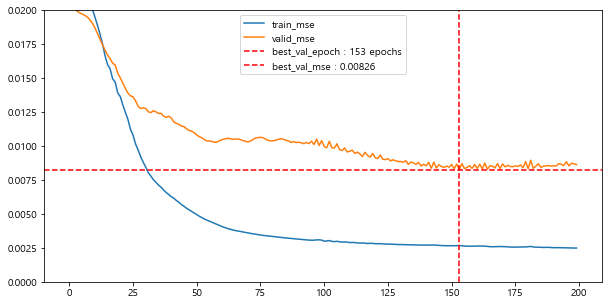

In [15]:
# Train model
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-2)
criterion = nn.MSELoss(size_average = True)
num_epochs  = 200
hist = np.zeros(num_epochs)
train_error = []
valid_error = []
hist = {'best_val_error': 100,
        'best_val_epoch': 0}
for t in range(num_epochs):
    train_trend_pred = model(train_time, train_notime)
    loss = criterion(train_trend_pred, train_y[:,:,trendcycle]) ### trend
    train_error.append(loss)
    valid_trend_pred = model(valid_time, valid_notime)
    valid_mse = float(criterion(valid_trend_pred, valid_y[:,:,trendcycle]).cpu()) ### trend
    valid_error.append(valid_mse)
    if hist['best_val_error'] >= valid_mse:
        hist['best_val_error'] = valid_mse
        hist['best_val_epoch'] = t
        torch.save(model, f'best_model/{model_name}.pkl')
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if t % 10 == 0 and t !=0:
        print(f"{t} Epochs train MSE: {loss.item():1.5f} // valid MSE: {valid_mse:1.5f}")
        
best_model = torch.load( f'best_model/{model_name}.pkl')
train_pred = best_model(train_time, train_notime)
valid_pred = best_model(valid_time, valid_notime)
print('train_error : ',criterion(train_pred, train_y[:,:,trendcycle]))
print('valid_error : ',criterion(valid_pred, valid_y[:,:,trendcycle]))
plot_hist(train_error, valid_error, hist, ylim = 0.02)
model_valid_scores[model_name] = float(criterion(valid_pred, valid_y[:,:,trendcycle]).cpu())

# 4. 6가지 모델의 검증데이터 성능 비교

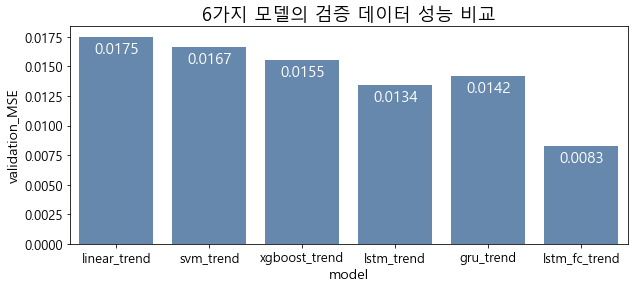

In [16]:
model_valid_scores = pd.DataFrame({"model"  : list(model_valid_scores.keys()),
                                    "validation_MSE": list(model_valid_scores.values())})
plot_models_valid_mse(model_valid_scores)
best_model_name = model_valid_scores.sort_values("validation_MSE").iloc[0]['model']

# 5. 변수 선택(Feature Selection)

In [2]:
features_name = ['card_use', 'holiday', 'day_corona','ondo', 'subdo',
                 'rain_snow','dayofyear_sin', 'dayofyear_cos', 'weekday_sin',
                  'weekday_cos', 'flow_trend', 'flow_cycle', 'ALL']

In [ ]:
best_model_name

# 5. 훈련 데이터와 검증 데이터의 성능 비교

In [17]:
try:
    best_model = torch.load( f'best_model/{best_model_name}.pkl')
except:
    with open( f'best_model/{best_model_name}.pkl', 'rb') as f:
        best_model = pickle.load(f)

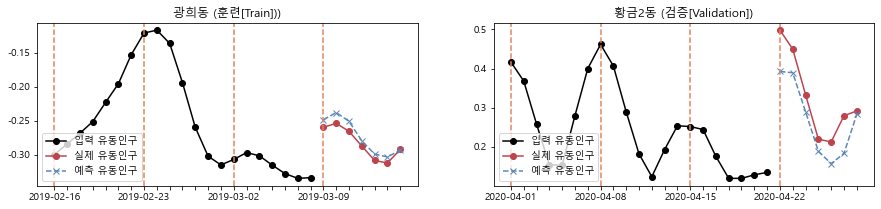

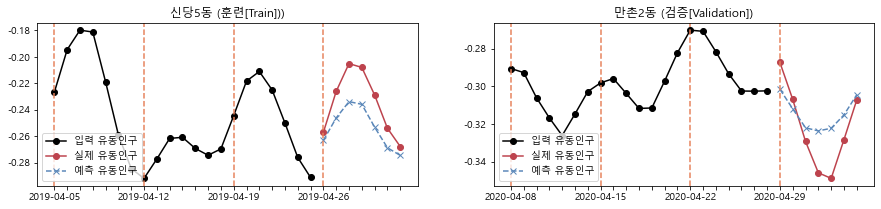

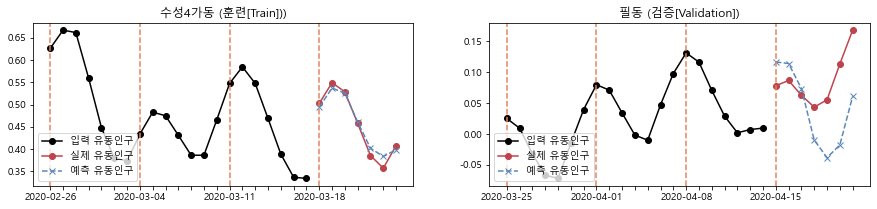

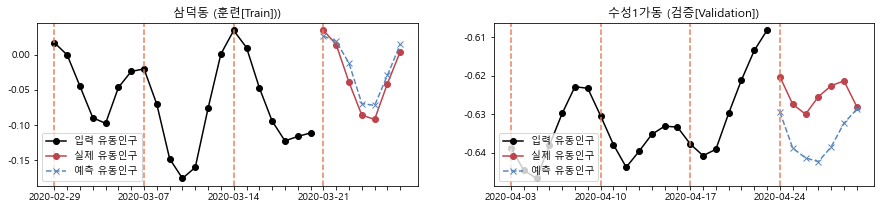

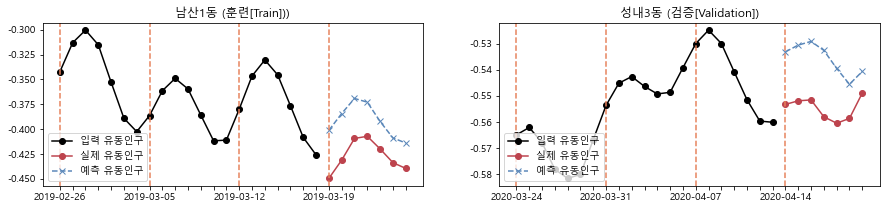

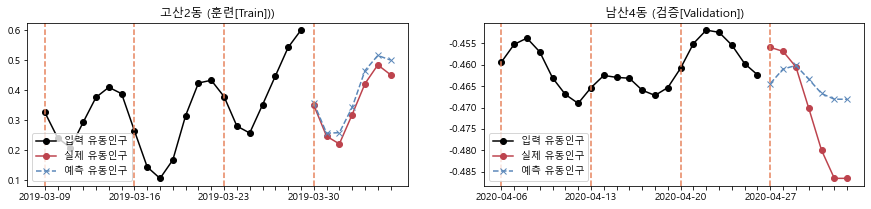

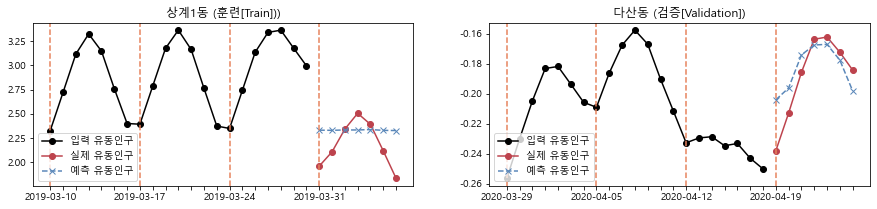

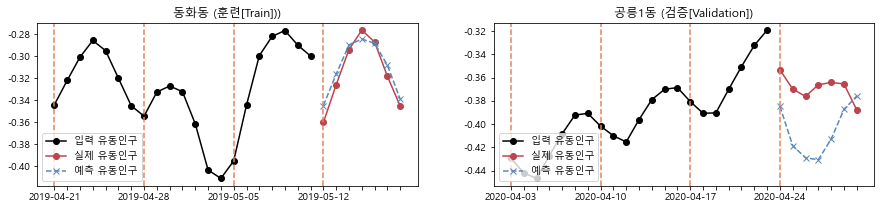

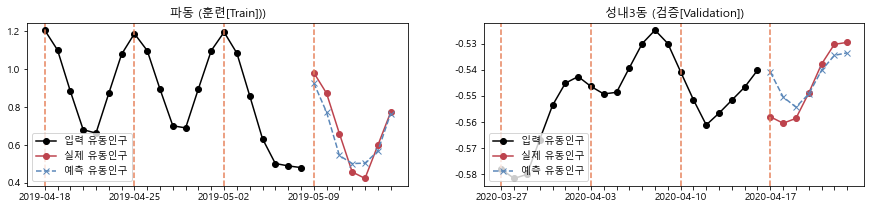

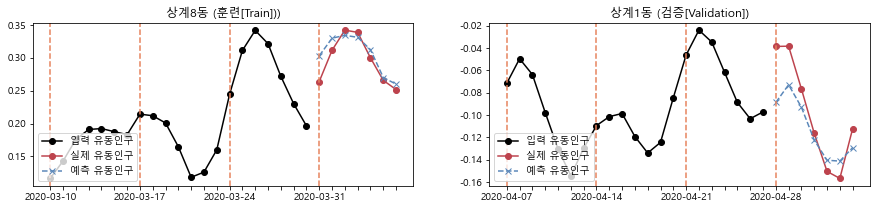

In [18]:
try:
    valid_trend_pred = best_model(valid_time, valid_notime)
    train_trend_pred = best_model(train_time, train_notime)
    
    train_x_np, train_y_np, train_pred_np,\
    valid_time_x_np, valid_y_np, valid_pred_np= tensor2numpy([train_time[:,:,trendcycle-2], train_y[:,:,trendcycle], train_trend_pred,
                                                            valid_time[:,:,trendcycle-2], valid_y[:,:,trendcycle], valid_trend_pred])
except:
    X = np.array(train_time[:,:,:].cpu()).reshape(-1,21*12)
    y = np.array(train_y[:,:,trendcycle].cpu())
    val_X = np.array(valid_time[:,:,:].cpu()).reshape(-1,21*12)
    val_y = np.array(valid_y[:,:,trendcycle].cpu())
    
    train_pred = best_model.predict(X)
    valid_pred = best_model.predict(val_X)
    
    train_x_np, train_y_np, train_pred_np,\
    valid_time_x_np, valid_y_np, valid_pred_np = np.array(train_time[:,:,trendcycle-2].cpu()).reshape(-1,21), y, train_pred,\
                                                  np.array(valid_time[:,:,trendcycle-2].cpu()).reshape(-1,21), val_y, valid_pred, 
    
plot_predict(train_x_np, train_y_np, train_pred_np,\
                valid_time_x_np, valid_y_np, valid_pred_np)

trend_result_list = [train_x_np, train_y_np, train_pred_np,\
    valid_time_x_np, valid_y_np, valid_pred_np]

### morning result
path = '../data/train_results/morning_results/'
with open(path + 'm_trend_results_list.pkl', 'wb') as f:
    pickle.dump(trend_result_list, f)

# 6. 평가(test set)

In [19]:
try:
    test_pred = best_model(test_time, test_notime)
    print('test_error : ',criterion(test_pred, test_y[:,:,trendcycle]))
except:
    test_x = np.array(test_time[:,:,:].cpu()).reshape(-1,21*12)
    test_pred = best_model.predict(test_x)
    print('test_error : ',np.mean(((test_pred) - (np.array(test_y[:,:,trendcycle].cpu())))**2))

test_error :  tensor(0.0621, device='cuda:0', grad_fn=<MseLossBackward>)


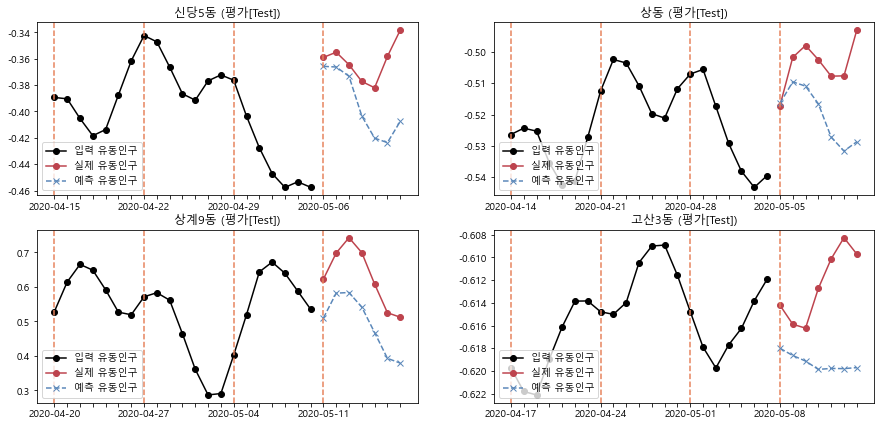

In [20]:
try:
    test_pred = best_model(test_time, test_notime)
    test_time_x_np, test_y_np, test_pred_np = tensor2numpy([test_time[:,:,trendcycle-2], test_y[:,:,trendcycle], test_pred])
except:
    testX, test_time_x_np, test_y_np = tensor2numpy([test_time, test_time[:,:,trendcycle-2], test_y[:,:,trendcycle]])
    test_pred_np = best_model.predict(testX.reshape(-1,21*12))

# plot result
plot_test_predict(test_time_x_np, test_y_np, test_pred_np)

# save result
trend_result_list = [test_time_x_np, test_y_np, test_pred_np]
path = '../data/train_results/morning_results/'
with open(path + 'm_trend_results_test.pkl', 'wb') as f:
    pickle.dump(trend_result_list, f)

# 7. 6월 유동인구 추세(Trend) 성분 예측

In [21]:
with open('../data/predict_june/preprocess_june/morning_june_time.pkl', 'rb') as f:
    train_time = pickle.load(f)
with open('../data/predict_june/preprocess_june/morning_june_notime.pkl', 'rb') as f:
    train_notime = pickle.load(f)

cycle_size =train_time[:,:,-2].max(axis = 1) - train_time[:,:, -2].min(axis = 1)
train_notime = np.concatenate([train_notime, cycle_size.reshape(-1,1)], axis = 1)

try:
    train_time_x, train_notime_x = numpy2tensor([train_time[:,:,3:].astype(np.float64), train_notime.astype(np.float64)])
    pred_y = best_model(train_time_x, train_notime_x)
    pred_y = np.array(pred_y.cpu().detach())
except:
    pred_y = best_model.predict(train_time[:,:,3:].astype(np.float64).reshape(-1,21*12))



path = '../data/predict_june/predict_cycle_trend/'
with open(path + 'june_morning_trend_pred.pkl', 'wb') as f:
    pickle.dump(pred_y, f)